# **Math-485: Topics in Data Science**

## **Textual Data Unit Project**

### Josh Winnes
---
## **Objective**

To produce an experimental evaluation of classifier performance on UN SDG labeled textual data. The evaluation should be conducted on a set of algorithms in combination with a set of NLP preprocessing steps, and conclude with the best performing algorithm with the associated preprocessing steps.

## **Specifications**

* prepare data as having been done in class and homework  
* write a function that will   
  * takes in a corpus (such as prepared so far) as input, and  
  * takes another parameter of “classifier\_algorithm” for the algorithm to use, the parameter settings for the algorithm should be part of the “classifier\_algorithm” parameter  
  * run the classifier with train\_test split, i.e., train on the training set and test on the test set  
  * report the metrics of precision, recall, f1\_score, and accuracy  
* run various classification algorithms on the UN SDG labeled data we have been using in class  
  * multinomial naive bayes   
  * multilayer perceptron (sklearn.neural\_network.MLPClassifier, note to use min\_df to ensure computation can be completed in reasonable time)  
  * ridge regression (sklearn.linear\_model.Ridge)  
  * combine with different preprocessing settings  
    * use count vectors vs. tfidf vectors  
    * use unigram only, bigram only, or both  
* evaluate all performance results in one table, with all configurations, bold face the numbers that give the best performance

for example, for one configuration, e.g., bigram with min\_df \= 3, the portion of table should contain

|  | MultinomialNB | MLP | Ridge |
| :---- | :---- | :---- | :---- |
| precision |  |  |  |
| recall |  |  |  |
| f1 |  |  |  |
| accuracy |  |  |  |

* for each SDG, what are the most differentiating features according to the classifier?  
* are there any overlaps between the SDG vocabularies?

## **Deliverables**

* A self contained python jupyter notebook that implements the specifications.  
* take the main text content from these pages, and feed them into your classifier and see how your model classifies them. Are the classifications reasonable? find a case where your classification is not reasonable and explain what the model does that leads to the not ideal classification.  
  [http://gianttortoise.org/en/beyond-tracking](http://gianttortoise.org/en/beyond-tracking)  
  [https://www.dhs.gov/blue-campaign/what-human-trafficking](https://www.dhs.gov/blue-campaign/what-human-trafficking)  
  [https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers](https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers)  
  [https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/](https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/)

## **Important note (to help reduce computation time if that is an issue)**

* when the classification takes too long to run on your computer (most likely they will on this project), set min\_df in the vectorizer to reduce the vocabulary size, which will reduce the matrix size drastically.   
* if you choose to run experiments on fewer number of SDGs, please be sure to include SDG 8 in your collection, and choose several others among  \[2,3,4,8,9,10,14,15,16\], to show your work on multiple classes

---

### **Scraping the Websites using Beautiful Soup 4**
This is necessary in order to get the text data into a dataframe so we can actually process the text in the website using our sklearn models later

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# List of URLs to scrape
urls = [
    "http://gianttortoise.org/en/beyond-tracking",
    "https://www.dhs.gov/blue-campaign/what-human-trafficking",
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers",
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/"
]

# Dictionary that links URLs to HTML Class names to locate the main text
class_name_dict = {
    "http://gianttortoise.org/en/beyond-tracking":'elementor-container elementor-column-gap-default',
    "https://www.dhs.gov/blue-campaign/what-human-trafficking":'field field--name-body field--type-text-with-summary field--label-hidden field__item',
    "https://www.dol.gov/agencies/odep/program-areas/individuals/older-workers":'field field--name-field-p-text field--type-text-long field--label-hidden clearfix',
    "https://michigantoday.umich.edu/2022/08/26/positively-breaking-the-age-code/":'post'
}

# Function to extract the main text from a webpage
def extract_main_text(url, class_name):
    response = requests.get(url)

    soup = BeautifulSoup(response.content, "html.parser")

    # Extract main text        
    divs = soup.find_all('div', class_ = class_name)
    text = ''
    for div in divs:
        p_elements = div.find_all('p')
        li_elements = div.find_all('li')
        for p in p_elements:
            text += p.get_text() + " "
        for li in li_elements:
            text += li.get_text() + ' '

    return text

data = {"url": [], "text": []}

for url in urls:
    text = extract_main_text(url, class_name_dict.get(url))
    data["url"].append(url)
    data["text"].append(text)

# Create a DataFrame
df = pd.DataFrame(data)

df.head()

,url,text
0,http://gianttortoise.org/en/beyond-tracking,Having discovered some of the mechanisms gover...
1,https://www.dhs.gov/blue-campaign/what-human-t...,"Human trafficking involves the use of force, f..."
2,https://www.dol.gov/agencies/odep/program-area...,"Today, a confluence of factors is prompting Am..."
3,https://michigantoday.umich.edu/2022/08/26/pos...,"Scientist/author Becca Levy, BA ’87, is a prof..."


### **Importing the training data**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt
import matplotlib as mpl
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from langdetect import detect

In [3]:
data_dir = "/Users/joshwinnes/Library/Mobile Documents/com~apple~CloudDocs/Wheaton College/fall 2024/topics in data science/data/"
sdg_names = pd.read_csv(data_dir + "sdg_name_definition.csv")

text_file_name = "osdg-community-data-v2024-04-01.csv"
text_df = pd.read_csv(data_dir + text_file_name,sep = "\t",  quotechar='"')
text_df.drop(text_df.columns.values[0],axis = 1, inplace=True)
text_df = text_df.query("agreement > 0.5 and (labels_positive - labels_negative) > 2").reset_index(drop=True)
text_df["lang"] = text_df["text"].apply(lambda x: detect(x))
text_df = text_df.query("lang == 'en'")
text_df.reset_index(inplace=True,drop=True)

In [4]:
corpus = text_df.text
count_vectorizer = CountVectorizer(stop_words='english')
count_vectorizer.fit(corpus)
count_vector = count_vectorizer.transform(corpus).toarray() 
count_vector_df = pd.DataFrame(count_vector, columns=count_vectorizer.get_feature_names_out())
term_freq = pd.DataFrame({"term": count_vector_df.columns.values, "freq" : count_vector_df.sum(axis=0)})
term_freq.sort_values(by="freq", ascending=False)

,term,freq
countries,countries,8493
women,women,6017
development,development,5889
public,public,4819
social,social,4754
...,...,...
escapement,escapement,1
paim,paim,1
paiking,paiking,1
paik,paik,1


In [5]:
corpus = text_df.text
sdg_num = text_df.sdg
X_train, X_test, y_train, y_test = \
    train_test_split(corpus, sdg_num, test_size=0.20, random_state=11)
    
X_train_count_vector = count_vectorizer.transform(X_train) 
X_test_count_vector = count_vectorizer.transform(X_test) 

### **Training the Models**

### Multinomial Naive Bayes

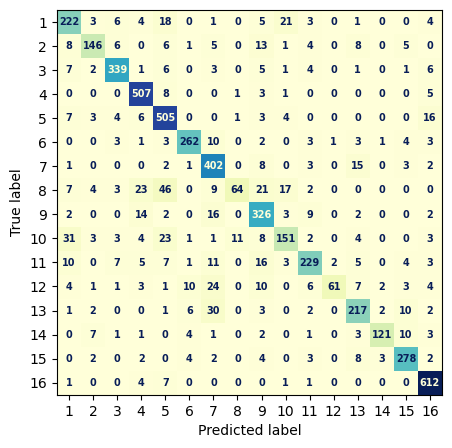

In [6]:
count_multinomialNB_clf = MultinomialNB().fit(X_train_count_vector, y_train)
y_pred = count_multinomialNB_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [7]:
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.7375    0.7708    0.7538       288
           2     0.8439    0.7192    0.7766       203
           3     0.9088    0.9016    0.9052       376
           4     0.8817    0.9657    0.9218       525
           5     0.7953    0.9199    0.8530       549
           6     0.9034    0.8851    0.8942       296
           7     0.7806    0.9199    0.8445       437
           8     0.8312    0.3265    0.4689       196
           9     0.7599    0.8670    0.8099       376
          10     0.7438    0.6163    0.6741       245
          11     0.8419    0.7558    0.7965       303
          12     0.9531    0.4453    0.6070       137
          13     0.7920    0.7862    0.7891       276
          14     0.9380    0.7857    0.8551       154
          15     0.8742    0.9026    0.8882       308
          16     0.9175    0.9776    0.9466       626

    accuracy                         0.8389      5295
   macro avg     0.8439   

### Multilayer Perceptron

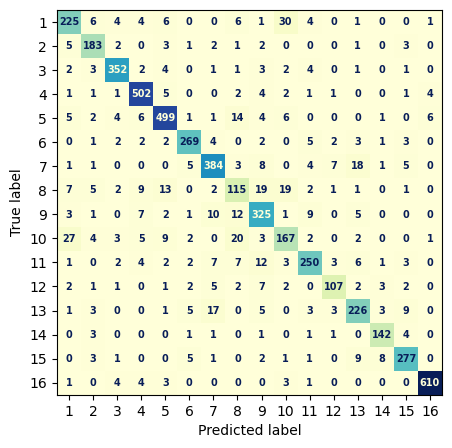

In [8]:
count_MLP_clf = MLPClassifier().fit(X_train_count_vector, y_train)
y_pred = count_MLP_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [9]:
print(metrics.classification_report(y_test,y_pred, digits = 4))

              precision    recall  f1-score   support

           1     0.8007    0.7812    0.7909       288
           2     0.8433    0.9015    0.8714       203
           3     0.9312    0.9362    0.9337       376
           4     0.9211    0.9562    0.9383       525
           5     0.9073    0.9089    0.9081       549
           6     0.9150    0.9088    0.9119       296
           7     0.8828    0.8787    0.8807       437
           8     0.6284    0.5867    0.6069       196
           9     0.8166    0.8644    0.8398       376
          10     0.7076    0.6816    0.6944       245
          11     0.8711    0.8251    0.8475       303
          12     0.8560    0.7810    0.8168       137
          13     0.8218    0.8188    0.8203       276
          14     0.8875    0.9221    0.9045       154
          15     0.8964    0.8994    0.8979       308
          16     0.9807    0.9744    0.9776       626

    accuracy                         0.8750      5295
   macro avg     0.8542   

### Ridge Regressor

In [10]:
from sklearn.linear_model import RidgeClassifierCV

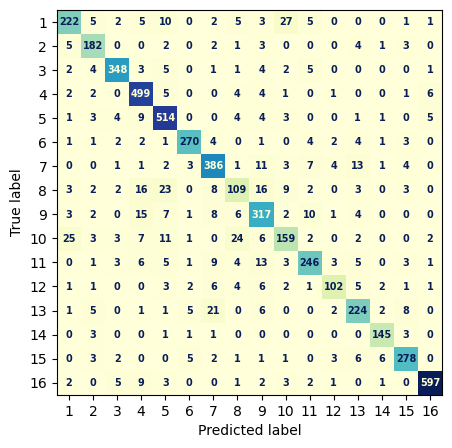

In [11]:
count_ridge_clf = RidgeClassifierCV(alphas=[0.1, 1.0, 10.0], cv=5, scoring='accuracy').fit(X_train_count_vector, y_train)
y_pred_ridge = count_ridge_clf.predict(X_test_count_vector)
fig, ax = plt.subplots(figsize=(15, 5))
font = {'family': 'sans-serif', 'weight': 'heavy','size': 7,}
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_ridge, text_kw=font, ax=ax, cmap=mpl.colormaps["YlGnBu"],colorbar=None)

In [12]:
print(metrics.classification_report(y_test,y_pred_ridge, digits = 4))

              precision    recall  f1-score   support

           1     0.8284    0.7708    0.7986       288
           2     0.8387    0.8966    0.8667       203
           3     0.9355    0.9255    0.9305       376
           4     0.8709    0.9505    0.9089       525
           5     0.8668    0.9362    0.9002       549
           6     0.9343    0.9122    0.9231       296
           7     0.8578    0.8833    0.8703       437
           8     0.6606    0.5561    0.6039       196
           9     0.7985    0.8431    0.8202       376
          10     0.7395    0.6490    0.6913       245
          11     0.8662    0.8119    0.8382       303
          12     0.8571    0.7445    0.7969       137
          13     0.8266    0.8116    0.8190       276
          14     0.9062    0.9416    0.9236       154
          15     0.9026    0.9026    0.9026       308
          16     0.9723    0.9537    0.9629       626

    accuracy                         0.8684      5295
   macro avg     0.8539   

After training all the models, it looks like the MLP Classifier performed the best. Typically, I'd then use GridsearchCV to fine tune the MLP Classifier to get an even better one, but that will take too long. So, since the RidgeClassifier only scored marginally lower than the MLP Classifier, but has a way shorter training time, I'll move forward with the RidgeClassifier.

### **Fine Tuning the Model**

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    #'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (100, 100)],  # Number of neurons per layer
    'activation': ['relu', 'tanh', 'logistic'],  # Activation functions
    'solver': ['adam', 'sgd'],  # Optimization solvers
    'alpha': [0.0001, 0.001, 0.01],  # Regularization term
    'learning_rate': ['constant'],  # Learning rate schedule
    'learning_rate_init': [0.001, 0.01, 0.1],  # Initial learning rate
    'max_iter': [5, 10, 20],  # Number of iterations
}

model = MLPClassifier()

search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy')
search.fit(X_train_count_vector, y_train)

print(search.best_params_)
print(search.best_score_)

/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/joshwinnes/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (5) reached and the optimization hasn't converged yet.
  war

At this point, changing the alpha isn't doing anything anymore so I'm happy with this classifier.

In [ ]:
COUNT_CLASSIFIER = search.best_estimator_

NameError: name 'search' is not defined

### **Classifying the Websites**

In [ ]:
text_to_predict = df.text
text_to_predict_transformed = count_vectorizer.transform(text_to_predict)

print('Count MLP Classifier Predicitions: ', COUNT_CLASSIFIER.predict(text_to_predict_transformed))


In [ ]:
sdg_names